In [175]:
import cv2
import numpy as np
import os
import json
from matplotlib import pyplot as plt

with open("data/input.json", "r") as f:
    input_data = json.load(f)

image_paths = input_data["image_files"]


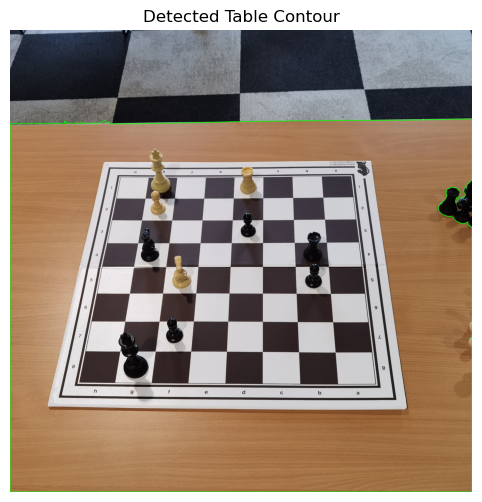

In [176]:
image = cv2.imread(image_paths[5])

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_brown = np.array([10, 30, 100])
upper_brown = np.array([30, 255, 255])

mask = cv2.inRange(hsv, lower_brown, upper_brown)

kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

table_contour = max(contours, key=cv2.contourArea)

contour_image = image.copy()
cv2.drawContours(contour_image, [table_contour], -1, (0, 255, 0), 3)

contour_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.title("Detected Table Contour")
plt.imshow(contour_rgb)
plt.axis('off')
plt.show()


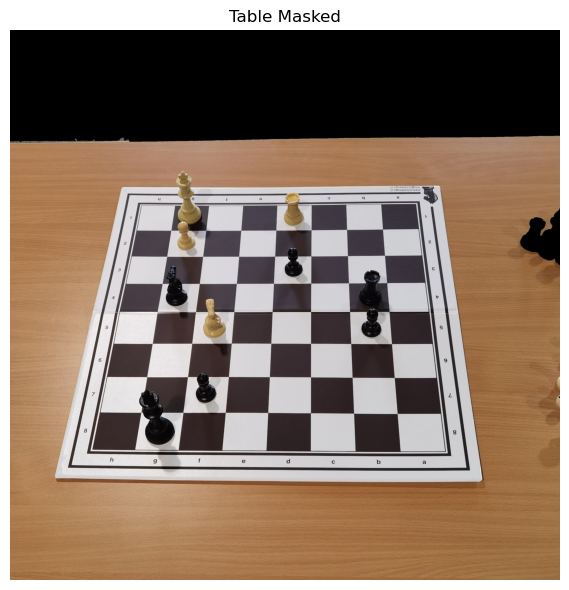

In [177]:
table_mask = np.zeros_like(image)
cv2.drawContours(table_mask, [table_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
masked_image = cv2.bitwise_and(image, table_mask)

masked_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)

# Display both results side-by-side
plt.figure(figsize=(12, 6))

plt.plot(1, 2, 2)
plt.title("Table Masked")
plt.imshow(masked_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()


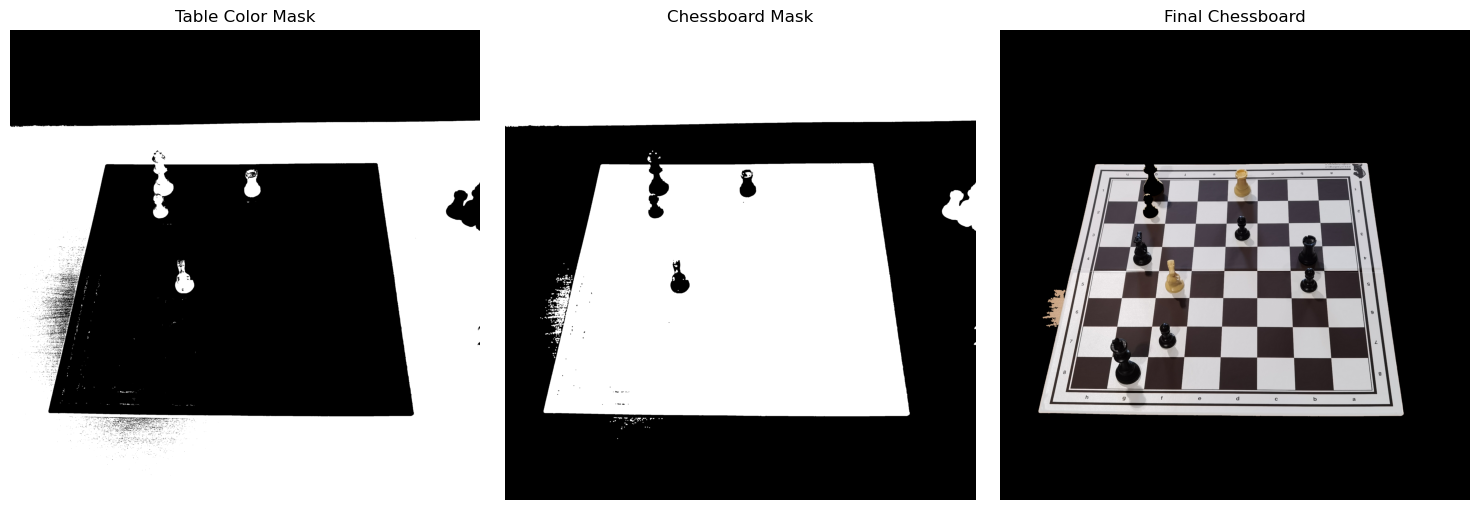

In [178]:

hsv = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)

lower_brown = np.array([10, 50, 50])   # Hue, Saturation, Value
upper_brown = np.array([30, 255, 200]) # Narrower range than before

table_color_mask = cv2.inRange(hsv, lower_brown, upper_brown)

chessboard_mask = cv2.bitwise_not(table_color_mask)

kernel = np.ones((3,3), np.uint8)
chessboard_mask = cv2.morphologyEx(chessboard_mask, cv2.MORPH_CLOSE, kernel)
chessboard_mask = cv2.morphologyEx(chessboard_mask, cv2.MORPH_OPEN, kernel, iterations=2)

contours, _ = cv2.findContours(chessboard_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    chessboard_contour = max(contours, key=cv2.contourArea)
    
    final_mask = np.zeros_like(chessboard_mask)
    cv2.drawContours(final_mask, [chessboard_contour], -1, 255, cv2.FILLED)
    
    chessboard_only = cv2.bitwise_and(masked_image, masked_image, mask=final_mask)
    
    # 
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Table Color Mask")
    plt.imshow(table_color_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Chessboard Mask")
    plt.imshow(chessboard_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Final Chessboard")
    final_rgb = cv2.cvtColor(chessboard_only, cv2.COLOR_BGR2RGB)
    plt.imshow(final_rgb)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No chessboard found - adjust color thresholds")

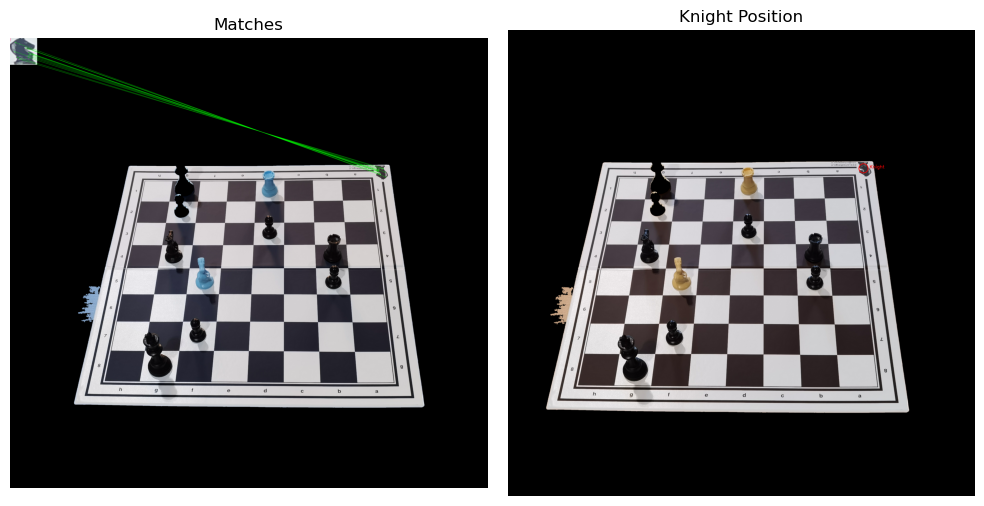

Knight found at position: (2338, 916)


In [179]:
import cv2
import numpy as np

# Load images - replace these paths with your actual images
knight_template = cv2.imread("knight.png", cv2.IMREAD_GRAYSCALE)  # Your knight symbol

chessboard_img= cv2.cvtColor(chessboard_only, cv2.COLOR_BGR2GRAY)
chessboard_color = chessboard_only.copy()

# Color versions for display
knight_template_color = cv2.imread("knight.png")


# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors
kp1, des1 = sift.detectAndCompute(knight_template, None)
kp2, des2 = sift.detectAndCompute(chessboard_img, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # Higher = more accurate but slower

flann = cv2.FlannBasedMatcher(index_params, search_params)

# Perform matching
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test (Lowe's criteria)
good_matches = []
ratio_threshold = 0.7  # Adjust this if needed
for m, n in matches:
    if m.distance < ratio_threshold * n.distance:
        good_matches.append(m)

# Draw matches
match_output = cv2.drawMatches(
    knight_template_color, kp1, 
    chessboard_color, kp2,
    good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchColor=(0, 255, 0)  # Green matches
)

# Find the knight location (average of good matches)
if len(good_matches) > 0:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Calculate average position
    knight_position = np.mean(dst_pts, axis=0)[0]
    
    # Draw a circle at the found position
    cv2.circle(chessboard_color, (int(knight_position[0]), int(knight_position[1])), 
               30, (0, 0, 255), 3)
    cv2.putText(chessboard_color, "Knight", 
               (int(knight_position[0]) + 40, int(knight_position[1])),
               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Matches")
plt.imshow(match_output)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Knight Position")
plt.imshow(cv2.cvtColor(chessboard_color, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()

# Print position if found
if len(good_matches) > 0:
    print(f"Knight found at position: ({int(knight_position[0])}, {int(knight_position[1])})")
else:
    print("Knight not found - try adjusting the ratio threshold")

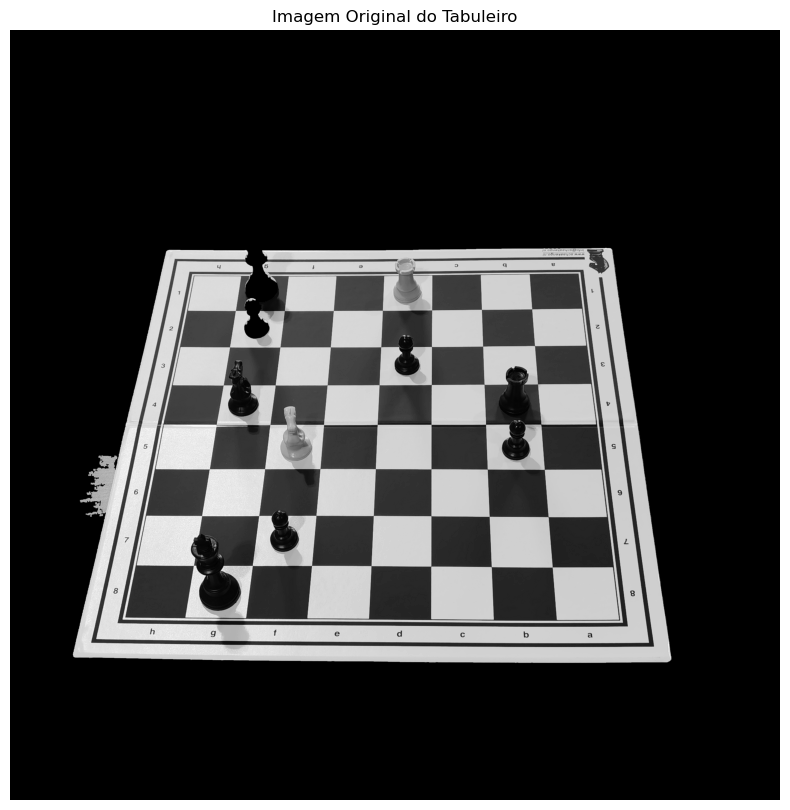

/tmp/ipykernel_5792/424826433.py:59: RuntimeWarning: overflow encountered in scalar subtract
  distance = np.sqrt((group[0] - center[0]) ** 2 + (group[1] - center[1]) ** 2)


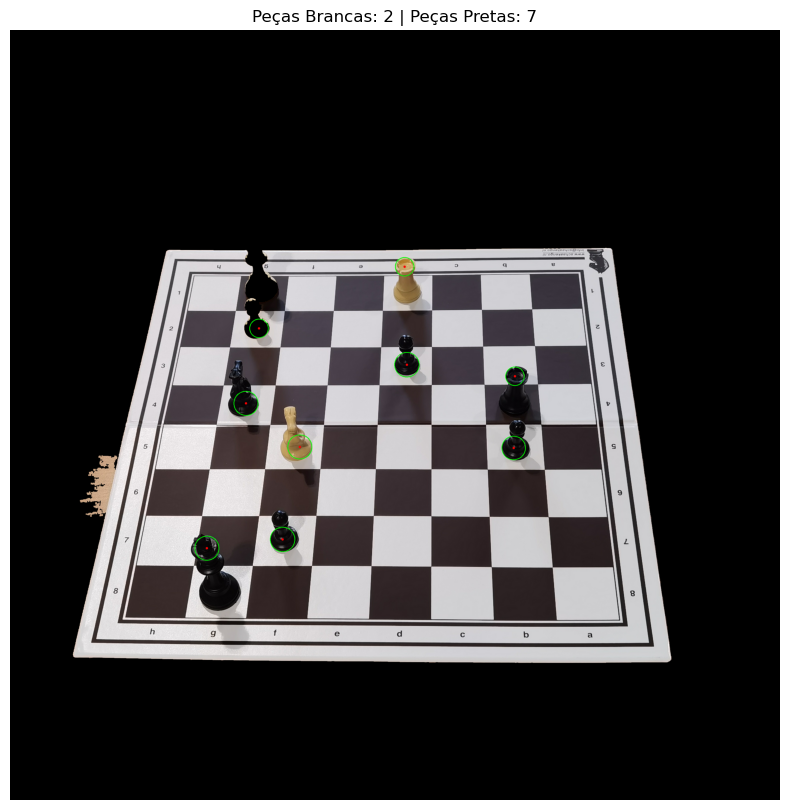

Peças Brancas: 2
Peças Pretas: 7


In [180]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carregar a imagem do tabuleiro de xadrez (imagem já pré-processada)
chessboard_img = cv2.cvtColor(chessboard_only, cv2.COLOR_BGR2GRAY)

# Mostrar a imagem original do tabuleiro
plt.figure(figsize=(10, 10))
plt.title("Imagem Original do Tabuleiro")
plt.imshow(chessboard_img, cmap='gray')
plt.axis('off')
plt.show()

# Usar um filtro para melhorar a imagem (opcional, pode ser ajustado conforme necessário)
blurred = cv2.GaussianBlur(chessboard_img, (5, 5), 0)

# Detectar círculos usando a Transformada de Hough
circles = cv2.HoughCircles(
    blurred, 
    cv2.HOUGH_GRADIENT, dp=1.2, minDist=150, 
    param1=50, param2=30, minRadius=30, maxRadius=50  # Aumente minRadius e maxRadius
)

# Se círculos forem detectados
if circles is not None:
    circles = np.uint16(np.around(circles))  # Arredondar os círculos detectados
    
    # Criar uma cópia da imagem para desenhar os círculos
    chessboard_color = chessboard_only.copy()

    # Inicializar contadores para as peças brancas e pretas
    white_piece_count = 0
    black_piece_count = 0

    # Processar cada círculo detectado
if circles is not None:
    circles = np.uint16(np.around(circles))  # Arredondar os círculos detectados
    
    # Criar uma cópia da imagem para desenhar os círculos
    chessboard_color = chessboard_only.copy()

    # Inicializar contadores para as peças brancas e pretas
    white_piece_count = 0
    black_piece_count = 0

    # Lista para armazenar as posições dos círculos (para agrupar os próximos)
    grouped_circles = []

    # Filtrar círculos próximos
    for i in circles[0, :]:
        center = (i[0], i[1])  # Centro do círculo (x, y)
        radius = i[2]  # Raio do círculo

        # Verificar se o círculo é suficientemente distante de outros círculos já detectados
        is_near_existing_circle = False
        for group in grouped_circles:
            # Verifica a distância entre os centros dos círculos
            distance = np.sqrt((group[0] - center[0]) ** 2 + (group[1] - center[1]) ** 2)
            if distance < 30:  # Se a distância for menor que 30 pixels, considera como a mesma peça
                is_near_existing_circle = True
                break
        
        # Se o círculo não for muito próximo de outro, adiciona à lista de círculos detectados
        if not is_near_existing_circle:
            grouped_circles.append(center)
            
            # Desenhar o círculo na imagem
            cv2.circle(chessboard_color, center, radius, (0, 255, 0), 2)  # Verde para círculos detectados
            cv2.rectangle(chessboard_color, (center[0] - 2, center[1] - 2), (center[0] + 2, center[1] + 2), (0, 0, 255), 3)

            # Extrair a região da peça no círculo (apenas o canal de brilho)
            piece_region = chessboard_only[center[1] - radius:center[1] + radius, center[0] - radius:center[0] + radius]
            
            # Converter para escala de cinza para pegar apenas a intensidade
            gray_piece_region = cv2.cvtColor(piece_region, cv2.COLOR_BGR2GRAY)

            # Calcular a média de intensidade (luminância) da região
            avg_intensity = np.mean(gray_piece_region)

            # Distinguir entre peças brancas e pretas (baseado na média de intensidade)
            if avg_intensity > 100:  # Limite para detectar peças brancas (ajuste esse valor conforme necessário)
                white_piece_count += 1
            else:
                black_piece_count += 1

    # Exibir a imagem com os círculos detectados
    plt.figure(figsize=(10, 10))
    plt.title(f"Peças Brancas: {white_piece_count} | Peças Pretas: {black_piece_count}")
    plt.imshow(cv2.cvtColor(chessboard_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Imprimir o número de peças brancas e pretas
    print(f"Peças Brancas: {white_piece_count}")
    print(f"Peças Pretas: {black_piece_count}")
else:
    print("Nenhum círculo detectado. Tente ajustar os parâmetros.")
